<div class="alert alert-success">
<h1>TABLE OF CONTENTS</h1>
</div>

* [Notes](#NOTES)
* [Setup](#SETUP)
* [Modeling Functions](#MODELING-FUNCTIONS)
* [Logistic Regression](#LOGISTIC-REGRESSION)
* [KNN](#KNN)
* [Random Forests](#RANDOM-FORESTS)
* [SVC](#SVC)
* [Clustering](#CLUSTERING)
* [DBSCAN](#DBSCAN)

<div class="alert alert-success">
<h1>NOTES</h1>
</div>

There are 3 sets of columns:

* **sec_cols**: security incident columns (outcome variables)
    * values = -1 (no), 1 (yes), and 0 (NA)
* **dem_cols**: demographic info columns (predictor variables)
* **hab_cols**: security habit columns (predictor variables)

<div class="alert alert-success">
<h1>SETUP</h1>
</div>

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Read in data

In [2]:
df = pd.read_csv('cybersecurity_clean_31Jul17.txt', sep = '\t', encoding = 'utf8')

## Create age groups

In [3]:
for i in range(0,len(df.age)):
    j = df.loc[i,'age']
    if(j >= 1) & (j <= 20): df.loc[i,'age_group'] = '1-20'
    elif(j >= 21) & (j <= 30): df.loc[i,'age_group'] = '21-30'
    elif(j >= 31) & (j <= 40): df.loc[i,'age_group'] = '31-40'
    elif(j >= 41) & (j <= 50): df.loc[i,'age_group'] = '41-50'
    elif(j >= 51) & (j <= 60): df.loc[i,'age_group'] = '51-60'
    elif(j >= 61) & (j <= 70): df.loc[i,'age_group'] = '61-70'
    elif(j >= 71) & (j <= 80): df.loc[i,'age_group'] = '71-80'
    elif(j >= 81): df.loc[i,'age_group'] = '81+'
    else: df.loc[i,'age_group'] = 'other'

## Create income groups

In [4]:
for i in range(0,len(df.inc)):
    j = df.loc[i,'inc']
    if(j == 1): df.loc[i,'inc_group'] = '$0-\n10,000'
    elif(j == 2): df.loc[i,'inc_group'] = '$10,000-\n19,999'
    elif(j == 3): df.loc[i,'inc_group'] = '$20,000-\n29,999'
    elif(j == 4): df.loc[i,'inc_group'] = '$30,000-\n39,999'
    elif(j == 5): df.loc[i,'inc_group'] = '$40,000-\n49,999'
    elif(j == 6): df.loc[i,'inc_group'] = '$50,000-\n59,999'
    elif(j == 7): df.loc[i,'inc_group'] = '$75,000-\n99,999'
    elif(j == 8): df.loc[i,'inc_group'] = '$100,000-\n149,999'
    elif(j == 9): df.loc[i,'inc_group'] = '$150,000+'
    else: df.loc[i,'inc_group'] = 'Other'

## Create subset dataframes

In [5]:
sec_cols = [s for s in df.columns if (s.lower().strip().startswith('sec')) |
           (s == 'ID') and
           (s != 'secur1')]
df_sec = df[sec_cols]

print('Security incident variables: ', sec_cols)

Security incident variables:  ['ID', 'secur2a', 'secur2b', 'secur2c', 'secur2d', 'secur2e', 'secur2f', 'secur2g']


In [6]:
exclude = ['habits4a', 'habits4b', 'habits1f', 'habits1fos', 'habits9os', 'habits1cnt']
hab_cols = [s for s in df.columns if (s.lower().strip().startswith('hab')) |
           (s == 'ID') |
           (s.lower().strip().startswith('wifi2')) and 
           (s not in exclude)]
df_hab = df[hab_cols]

print('Security habit variables: ', hab_cols)

Security habit variables:  ['ID', 'habits1a', 'habits1b', 'habits1c', 'habits1d', 'habits1e', 'habits2', 'habits3', 'habits4c', 'habits5', 'habits6', 'habits7', 'habits8', 'habits9', 'habits10', 'habits11', 'habits12', 'wifi2a', 'wifi2b', 'wifi2c', 'wifi2d']


In [7]:
temp = ['sex','age','educ2','hisp','race3m1','marital',
        'par','emplnw3','party','partyln','ideo','inc',
        'usr']
dem_cols = [s for s in df.columns if (s in temp) |
            (s == 'ID')]
df_dem = df[dem_cols]

print('Demographic variables: ', dem_cols)

Demographic variables:  ['ID', 'sex', 'age', 'educ2', 'hisp', 'race3m1', 'marital', 'par', 'emplnw3', 'party', 'partyln', 'ideo', 'inc', 'usr']


## Create dictionary of columns

In [8]:
dict_sec_cols = {'secur2a': 'SSN compromised',
                 'secur2b': 'Other sensitive info compromised',
                 'secur2c': 'Fraudulent charges on credit/debit card',
                 'secur2d': 'Someone took over email',
                 'secur2e': 'Someone took over social media account',
                 'secur2f': 'Someone opened line of credit/applied for loan under name',
                 'secur2g': 'Someone received tax refund under name'}

for key, val in dict_sec_cols.items():
    print(key,val)

secur2a SSN compromised
secur2b Other sensitive info compromised
secur2c Fraudulent charges on credit/debit card
secur2d Someone took over email
secur2e Someone took over social media account
secur2f Someone opened line of credit/applied for loan under name
secur2g Someone received tax refund under name


# Correlations

## Security incident variables

In [9]:
df_sec.corr()

,ID,secur2a,secur2b,secur2c,secur2d,secur2e,secur2f,secur2g
ID,1.000000,0.072080,0.040866,0.072952,0.104097,0.025571,0.000368,0.000181
secur2a,0.072080,1.000000,0.313427,0.184122,0.143392,0.049244,0.261746,0.214680
secur2b,0.040866,0.313427,1.000000,0.332780,0.210134,-0.005351,0.226394,0.050177
secur2c,0.072952,0.184122,0.332780,1.000000,0.187828,0.005934,0.197522,0.067478
secur2d,0.104097,0.143392,0.210134,0.187828,1.000000,0.161101,0.159210,0.071669
secur2e,0.025571,0.049244,-0.005351,0.005934,0.161101,1.000000,0.071255,0.077058
secur2f,0.000368,0.261746,0.226394,0.197522,0.159210,0.071255,1.000000,0.167113
secur2g,0.000181,0.214680,0.050177,0.067478,0.071669,0.077058,0.167113,1.000000


## Security habit variables

In [10]:
df_hab.corr()

,ID,habits1a,habits1b,habits1c,habits1d,habits1e,habits2,habits3,habits4c,habits5,...,habits7,habits8,habits9,habits10,habits11,habits12,wifi2a,wifi2b,wifi2c,wifi2d
ID,1.000000,0.183073,0.040823,0.110087,0.113262,0.136921,0.138584,0.139372,0.042008,0.064479,...,0.088516,0.151842,0.196000,0.157131,0.167480,0.024132,0.018453,0.004635,0.127739,0.132822
habits1a,0.183073,1.000000,0.055674,0.094748,0.088844,0.128422,0.238986,0.510972,0.095607,0.208840,...,-0.024552,0.202567,0.181217,0.197469,0.233134,0.070714,-0.217492,-0.224720,0.012738,0.029241
habits1b,0.040823,0.055674,1.000000,-0.051519,0.081297,0.067287,0.326063,0.259651,0.194989,0.127481,...,-0.096776,0.018599,0.013333,0.143170,0.122541,-0.005790,-0.110265,-0.194280,-0.100717,-0.052179
habits1c,0.110087,0.094748,-0.051519,1.000000,0.122601,0.202593,0.296074,0.113560,0.116470,0.136122,...,0.211228,0.210087,0.206472,0.028803,0.038755,0.012985,0.119003,-0.025907,0.180584,0.200469
habits1d,0.113262,0.088844,0.081297,0.122601,1.000000,0.262554,0.500973,0.115101,0.222221,0.143687,...,0.059604,0.181439,0.161058,0.113946,0.138885,-0.035652,0.037129,0.027421,0.080417,0.143080
habits1e,0.136921,0.128422,0.067287,0.202593,0.262554,1.000000,0.377690,0.055410,0.177683,0.203903,...,0.137085,0.146539,0.123842,0.054136,0.103644,0.000722,0.076992,0.024533,0.128029,0.193178
habits2,0.138584,0.238986,0.326063,0.296074,0.500973,0.377690,1.000000,0.220547,0.267822,0.148345,...,0.063957,0.197127,0.162676,0.113223,0.140825,0.001747,0.021864,-0.052551,0.050082,0.151428
habits3,0.139372,0.510972,0.259651,0.113560,0.115101,0.055410,0.220547,1.000000,0.057213,0.170201,...,-0.182065,0.237070,0.248696,0.271845,0.258158,0.102834,-0.398896,-0.392012,-0.173753,-0.158589
habits4c,0.042008,0.095607,0.194989,0.116470,0.222221,0.177683,0.267822,0.057213,1.000000,0.161064,...,0.044074,0.062927,0.026525,0.117245,0.162461,-0.052224,0.102532,0.039616,0.135923,0.208694
habits5,0.064479,0.208840,0.127481,0.136122,0.143687,0.203903,0.148345,0.170201,0.161064,1.000000,...,0.194327,0.146339,0.157304,0.129403,0.172596,0.003689,0.079722,0.074462,0.226470,0.253709


## Demographic variables

In [11]:
df_dem.corr()

,ID,sex,age,educ2,hisp,race3m1,marital,par,emplnw3,party,partyln,ideo,inc,usr
ID,1.000000,-0.119406,-0.343113,-0.010926,0.103976,0.112147,0.027175,0.106426,-0.204131,-0.005242,0.040151,0.059691,-0.111167,0.113990
sex,-0.119406,1.000000,0.100085,-0.032790,-0.002374,0.048729,-0.003834,-0.013111,0.221449,-0.049019,-0.093035,0.053488,0.005074,-0.043298
age,-0.343113,0.100085,1.000000,0.163559,-0.127582,-0.177774,-0.256278,-0.268125,0.250020,-0.088816,-0.123027,-0.120902,0.211119,-0.091053
educ2,-0.010926,-0.032790,0.163559,1.000000,0.026655,-0.050589,-0.072269,0.004125,-0.018757,-0.053825,-0.026698,-0.092463,0.155940,-0.038071
hisp,0.103976,-0.002374,-0.127582,0.026655,1.000000,0.487058,0.076618,0.127328,-0.023787,0.024166,0.034256,-0.041843,0.016345,0.055148
race3m1,0.112147,0.048729,-0.177774,-0.050589,0.487058,1.000000,0.108447,0.119486,0.032119,0.092149,0.107876,0.029285,-0.082905,0.061872
marital,0.027175,-0.003834,-0.256278,-0.072269,0.076618,0.108447,1.000000,-0.240432,0.144174,0.084820,-0.002562,0.122642,-0.015750,0.058423
par,0.106426,-0.013111,-0.268125,0.004125,0.127328,0.119486,-0.240432,1.000000,-0.224839,0.033337,0.036833,-0.089019,-0.067813,-0.042455
emplnw3,-0.204131,0.221449,0.250020,-0.018757,-0.023787,0.032119,0.144174,-0.224839,1.000000,0.050664,-0.042718,0.010396,0.044492,-0.092209
party,-0.005242,-0.049019,-0.088816,-0.053825,0.024166,0.092149,0.084820,0.033337,0.050664,1.000000,0.461573,0.168174,-0.002514,0.045377


## Security incident variables x Demographic variables

In [12]:
# Function to calculate correlations between columns in two dataframes

def corr(df1, df2):
    n = len(df1)
    v1, v2 = df1.values, df2.values
    sums = np.multiply.outer(v2.sum(0), v1.sum(0))
    stds = np.multiply.outer(v2.std(0), v1.std(0))
    
    return pd.DataFrame((v2.T.dot(v1) - sums / n) / stds / n,
                        df2.columns, df1.columns)

In [13]:
corr(df_dem, df_sec)

,ID,sex,age,educ2,hisp,race3m1,marital,par,emplnw3,party,partyln,ideo,inc,usr
ID,1.000000,-0.119406,-0.343113,-0.010926,0.103976,0.112147,0.027175,0.106426,-0.204131,-0.005242,0.040151,0.059691,-0.111167,0.113990
secur2a,0.072080,-0.030320,-0.035065,-0.008632,0.025851,0.014530,-0.104695,0.079287,-0.089091,0.028590,0.035654,0.023675,-0.022383,0.021950
secur2b,0.040866,0.004734,0.003588,-0.031545,-0.057366,-0.106956,-0.154279,0.055819,-0.119232,-0.007301,-0.027898,0.063029,-0.038112,0.050394
secur2c,0.072952,-0.046588,0.002489,0.003524,-0.090925,-0.118831,-0.203682,0.044959,-0.166174,-0.039088,0.072154,0.051133,-0.002749,0.080112
secur2d,0.104097,-0.002071,-0.147863,-0.039613,0.023180,-0.006598,-0.024650,0.125619,-0.144305,0.011587,0.038981,0.060056,-0.050390,0.017205
secur2e,0.025571,0.066730,-0.038598,-0.014350,0.067735,0.043507,0.135979,-0.055915,0.062612,-0.021987,-0.027047,0.021751,-0.025550,-0.018430
secur2f,0.000368,0.007001,0.028736,-0.028114,0.048383,0.036955,-0.043536,0.026722,-0.007297,0.002093,0.010621,0.003048,0.013215,0.015216
secur2g,0.000181,0.033695,0.058045,0.001262,0.036077,0.008052,0.006507,-0.017757,0.039903,-0.021220,-0.000901,0.013184,-0.013529,-0.003001


## Security incident variables x Security habit variables

In [14]:
corr(df_hab, df_sec)

,ID,habits1a,habits1b,habits1c,habits1d,habits1e,habits2,habits3,habits4c,habits5,...,habits7,habits8,habits9,habits10,habits11,habits12,wifi2a,wifi2b,wifi2c,wifi2d
ID,1.000000,0.183073,0.040823,0.110087,0.113262,0.136921,0.138584,0.139372,0.042008,0.064479,...,0.088516,0.151842,0.196000,0.157131,0.167480,0.024132,0.018453,0.004635,0.127739,0.132822
secur2a,0.072080,0.014996,0.024304,0.079987,0.007166,0.000794,0.050720,0.048192,0.069716,0.069366,...,0.014839,0.097182,0.107420,0.088302,0.079532,0.062710,0.003550,-0.007899,0.016219,0.065232
secur2b,0.040866,0.079479,0.062333,0.056242,0.084433,0.031960,0.125076,0.110201,0.146549,0.141250,...,0.018873,0.098475,0.080589,0.090738,0.062301,0.085787,0.023264,0.001006,0.065446,0.109405
secur2c,0.072952,0.085183,0.074544,0.093321,0.074937,0.054730,0.113237,0.140331,0.135357,0.116328,...,0.051354,0.136347,0.113375,0.093041,0.123850,0.019965,0.023707,-0.028231,0.063653,0.113082
secur2d,0.104097,0.141824,0.051424,0.100096,0.095092,0.142836,0.113582,0.140649,0.122851,0.121390,...,0.068926,0.120652,0.136967,0.060746,0.051788,0.074566,-0.000928,-0.036413,0.060873,0.052463
secur2e,0.025571,-0.184295,-0.100139,0.003569,0.038374,0.014606,-0.020672,-0.281991,-0.005471,-0.033966,...,0.211011,-0.018368,0.026638,-0.139129,-0.105102,0.048604,0.163846,0.153177,0.138271,0.039319
secur2f,0.000368,-0.048391,-0.025437,-0.019109,0.016545,0.013228,0.047447,-0.006194,0.045859,-0.043040,...,-0.013140,-0.010075,0.018298,0.029252,-0.012681,0.063624,0.053571,0.025124,-0.029764,0.004025
secur2g,0.000181,-0.061285,0.033503,0.008841,-0.002233,0.013687,-0.018018,-0.078129,0.013064,-0.034826,...,-0.012401,-0.071232,-0.055527,-0.024432,-0.046423,0.017813,-0.004281,-0.016321,-0.027180,-0.038973


<div class="alert alert-success">
<h1>MODELING FUNCTIONS</h1>
</div>

### Function: cv_optimize (cross-validation)
**Input**
- Classifier ('clf')
- Grid of hyperparameters implemented as a dictionary ('parameters')
- Training set, as a samples x features array ('XTrain')
- Set of labels ('ytrain)

**Function**

Takes the training set, splits it into `n_folds` parts, sets up `n_folds` folds, and carries out a cross-validation by splitting the training set into a training and validation section for each fold for us

**Output**
- Prints the best value of the parameters
- Returns the best classifier ('best')

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds, scorer):
    
    gs = GridSearchCV(clf,
                      param_grid = parameters,
                      cv = n_folds,
                      scoring = scorer)
    gs.fit(Xtrain, ytrain)
    print('\tBest Parameters: ' + str(gs.best_params_))
    print('\tScoring method used: ' + str(gs.scorer_) + ')')
    
    return gs.best_estimator_

### Function: do_classify
**Input**
- Classifier ('clf')
- Parameters, such as regularization parameter ('parameters')
- Dataframe containing features and target ('in_df')
- List of columns to use as features ('feature_names')
- Column to use as target ('targetname')
- Value to use as target - will be set to 1; all others will be set to 0 ('targetlval')
- ('standardize')
- ('train_size')

**Function**
- Splits dataframe into 80% training and 20% test
- Standardizes the dataset if desired (scales the data so that it has a mean of 0 and is described in units of its SD)
- Trains model on training set using cross-validation
- Uses cv_optimize to obtain best classifier and then re-trains on entire training set
- Calculates and prints training and test set accuracy

**Output**
- Returns split data and trained classifier

In [16]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

def do_classify(clf, parameters, in_df, feature_names, targetname, target1val, standardize, train_size, scorer):
    
    n_folds = 5
    
    # ============= Create X and y ============= #
    sub_df = in_df[feature_names]
    
    if standardize:
        sub_df_std = (sub_df - sub_df.mean())/sub_df.std()
    else:
        sub_df_std = sub_df
    
    # X = df with feature columns
    X = sub_df_std.values
    
    if clf == LogisticRegression:
        # y = array with 1 when value in target column matches targetlval, and 0 when it doesn't
        y = (in_df[targetname].values == target1val)*1
    else:
        y = in_df[targetname]
    
    # ============= Split into training and test sets ============= #
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    
    # ============= Create and fit model ============= #
    clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds, scorer)
    clf = clf.fit(Xtrain, ytrain)
    
    # ============= Calculate model metrics ============= #
    # calculate and print training and test set accuracy scores
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    
    print('\tAccuracy on training data: {:0.2f}'.format(training_accuracy))
    print('\tAccuracy on test data:     {:0.2f}'.format(test_accuracy))
    
    # calculate other metrics
    ypred = clf.predict(Xtest)
    classes = in_df[targetname].unique()
    calc_metrics(clf, ytest, ypred, classes)
    
    return clf, Xtrain, ytrain, Xtest, ytest

### Function: Calculate metrics
Calculates and prints precision, recall, and confusion matrix

In [17]:
from sklearn import metrics

def calc_metrics(clf, y_true, y_pred, classes):
    
    if len(classes) == 2:
        average_param = 'binary'
    else:
        average_param = 'weighted'
    
    # ============= Calculate precision, recall, F1, and Cohen's Kappa ============= #
    precision = metrics.precision_score(y_true,
                                        y_pred,
                                        average=average_param)
    
    recall = metrics.recall_score(y_true,
                                  y_pred,
                                  average=average_param)
    
    f1 = metrics.f1_score(y_true,
                          y_pred,
                          average=average_param)
    
    cohenk = metrics.cohen_kappa_score(y_true,
                                       y_pred)
    
    print('\tPrecision: ' + str(round(precision,2)))
    print('\tRecall: ' + str(round(recall,2))) 
    print('\tF1 Score: ' + str(round(f1,2)))
    print('\tCohen\'s Kappa: ' + str(round(cohenk,2)))
    
    # ============= Create and plot confusion matrix ============= #
    cnf_matrix = metrics.confusion_matrix(y_true, y_pred)
    np.set_printoptions(precision=2)

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes, False)
    plt.show()

### Function: Plot confusion matrix
Prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`

In [18]:
import itertools

def plot_confusion_matrix(cm, classes, normalize, cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Confusion matrix, with normalization'
    else:
        title = 'Confusion matrix, without normalization'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Function: Calculate proportion in classes
Given a dataframe and column, prints number of observations per class in column and proportion of total observations

In [19]:
def calc_prop_class(df, col):
    classes = df[col].unique()
    for c in classes:
        num_obs = sum(df[col] == c)
        total_obs = len(df[col])
        prop = round(100*(num_obs / total_obs),2)
        print('\tObservations in class ' + str(c) + ': ' + str(num_obs) + ' (' + str(prop) + '%)')    

<div class="alert alert-success">
<h1>LOGISTIC REGRESSION</h1>
</div>

### Perform logistic regression


Y = SECUR2A (SSN compromised)
	Observations in class -1: 867 (83.37%)
	Observations in class 1: 167 (16.06%)
	Observations in class 0: 6 (0.58%)

	X = DEMOGRAPHIC VARIABLES
	Best Parameters: {'C': 0.01, 'class_weight': {-1: 0.2, 1: 0.8}}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.70
	Accuracy on test data:     0.76
	Precision: 0.25
	Recall: 0.52
	F1 Score: 0.34
	Cohen's Kappa: 0.21


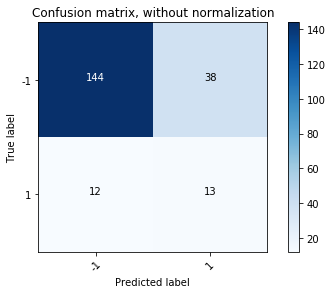


	X = SECURITY HABIT VARIABLES
	Best Parameters: {'C': 1e-06, 'class_weight': {-1: 0.2, 1: 0.8}}
	Scoring method used: <function _passthrough_scorer at 0x10a3a28c8>)
	Accuracy on training data: 0.84
	Accuracy on test data:     0.85
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: 0.0


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


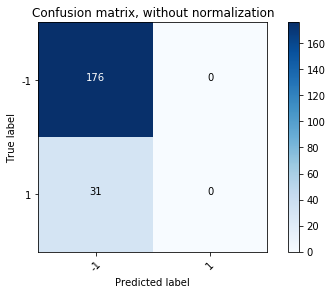


Y = SECUR2B (Other sensitive info compromised)
	Observations in class 1: 402 (38.65%)
	Observations in class -1: 628 (60.38%)
	Observations in class 0: 10 (0.96%)

	X = DEMOGRAPHIC VARIABLES
	Best Parameters: {'C': 0.01, 'class_weight': {-1: 0.4, 1: 0.6}}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.60
	Accuracy on test data:     0.62
	Precision: 0.5
	Recall: 0.66
	F1 Score: 0.57
	Cohen's Kappa: 0.24


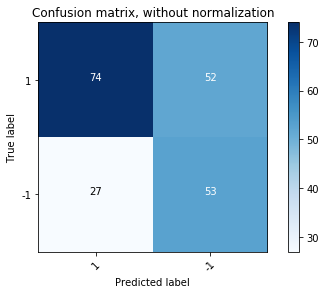


	X = SECURITY HABIT VARIABLES
	Best Parameters: {'C': 1e-06, 'class_weight': {-1: 0.5, 1: 0.5}}
	Scoring method used: <function _passthrough_scorer at 0x10a3a28c8>)
	Accuracy on training data: 0.60
	Accuracy on test data:     0.64
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: 0.0


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


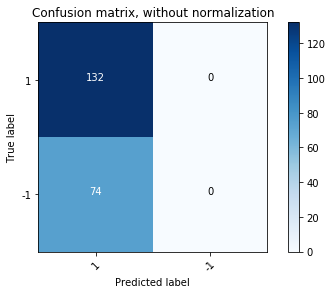


Y = SECUR2C (Fraudulent charges on credit/debit card)
	Observations in class 1: 475 (45.67%)
	Observations in class -1: 561 (53.94%)
	Observations in class 0: 4 (0.38%)

	X = DEMOGRAPHIC VARIABLES
	Best Parameters: {'C': 0.01, 'class_weight': {-1: 0.5, 1: 0.5}}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.62
	Accuracy on test data:     0.55
	Precision: 0.56
	Recall: 0.28
	F1 Score: 0.37
	Cohen's Kappa: 0.08


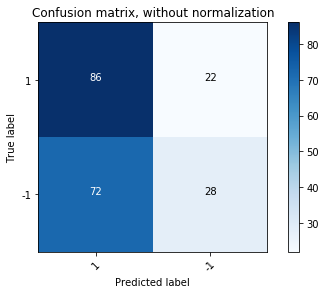


	X = SECURITY HABIT VARIABLES
	Best Parameters: {'C': 0.01, 'class_weight': {-1: 0.5, 1: 0.5}}
	Scoring method used: <function _passthrough_scorer at 0x10a3a28c8>)
	Accuracy on training data: 0.57
	Accuracy on test data:     0.53
	Precision: 0.41
	Recall: 0.13
	F1 Score: 0.2
	Cohen's Kappa: -0.02


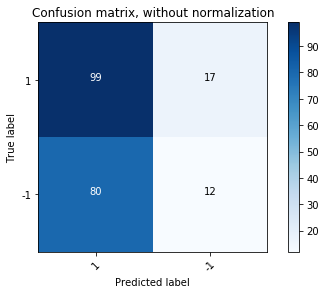


Y = SECUR2D (Someone took over email)
	Observations in class 1: 175 (16.83%)
	Observations in class -1: 855 (82.21%)
	Observations in class 0: 10 (0.96%)

	X = DEMOGRAPHIC VARIABLES
	Best Parameters: {'C': 0.0001, 'class_weight': {-1: 0.2, 1: 0.8}}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.69
	Accuracy on test data:     0.59
	Precision: 0.17
	Recall: 0.36
	F1 Score: 0.23
	Cohen's Kappa: -0.0


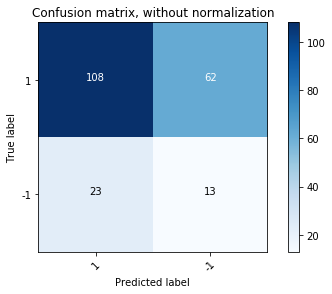


	X = SECURITY HABIT VARIABLES
	Best Parameters: {'C': 1e-06, 'class_weight': {-1: 0.2, 1: 0.8}}
	Scoring method used: <function _passthrough_scorer at 0x10a3a28c8>)
	Accuracy on training data: 0.84
	Accuracy on test data:     0.79
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: 0.0


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


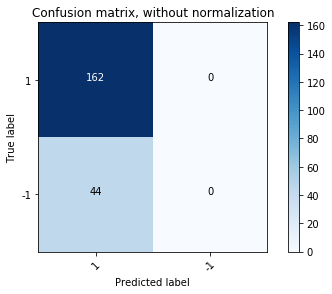


Y = SECUR2E (Someone took over social media account)
	Observations in class -1: 798 (76.73%)
	Observations in class 0: 119 (11.44%)
	Observations in class 1: 123 (11.83%)

	X = DEMOGRAPHIC VARIABLES
	Best Parameters: {'C': 0.01, 'class_weight': {-1: 0.2, 1: 0.8}}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.75
	Accuracy on test data:     0.71
	Precision: 0.11
	Recall: 0.26
	F1 Score: 0.16
	Cohen's Kappa: 0.01


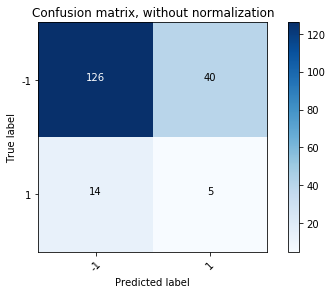


	X = SECURITY HABIT VARIABLES
	Best Parameters: {'C': 1e-06, 'class_weight': {-1: 0.2, 1: 0.8}}
	Scoring method used: <function _passthrough_scorer at 0x10a3a28c8>)
	Accuracy on training data: 0.86
	Accuracy on test data:     0.88
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: 0.0


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


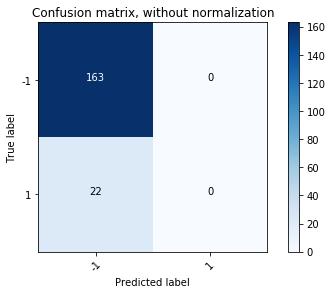


Y = SECUR2F (Someone opened line of credit/applied for loan under name)
	Observations in class -1: 871 (83.75%)
	Observations in class 1: 153 (14.71%)
	Observations in class 0: 16 (1.54%)

	X = DEMOGRAPHIC VARIABLES
	Best Parameters: {'C': 0.01, 'class_weight': {-1: 0.2, 1: 0.8}}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.81
	Accuracy on test data:     0.75
	Precision: 0.05
	Recall: 0.03
	F1 Score: 0.04
	Cohen's Kappa: -0.1


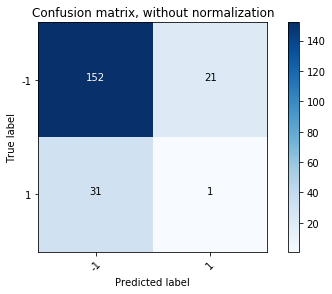


	X = SECURITY HABIT VARIABLES
	Best Parameters: {'C': 1e-06, 'class_weight': {-1: 0.2, 1: 0.8}}
	Scoring method used: <function _passthrough_scorer at 0x10a3a28c8>)
	Accuracy on training data: 0.85
	Accuracy on test data:     0.86
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: 0.0


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


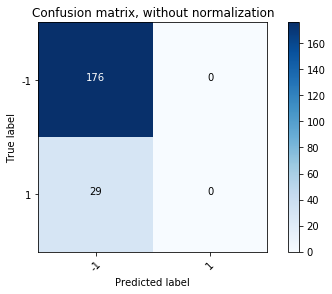


Y = SECUR2G (Someone received tax refund under name)
	Observations in class -1: 970 (93.27%)
	Observations in class 1: 57 (5.48%)
	Observations in class 0: 13 (1.25%)

	X = DEMOGRAPHIC VARIABLES
	Best Parameters: {'C': 1e-06, 'class_weight': {-1: 0.1, 1: 0.9}}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.95
	Accuracy on test data:     0.94
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: 0.0


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


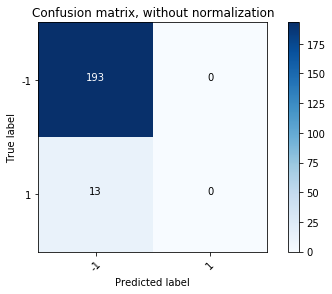


	X = SECURITY HABIT VARIABLES
	Best Parameters: {'C': 1e-06, 'class_weight': {-1: 0.1, 1: 0.9}}
	Scoring method used: <function _passthrough_scorer at 0x10a3a28c8>)
	Accuracy on training data: 0.94
	Accuracy on test data:     0.95
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: 0.0


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


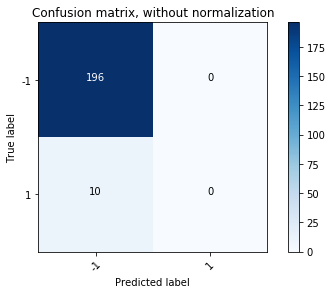

In [20]:
from sklearn.linear_model import LogisticRegression

# create dictionary of parameters
dict_params = {'C': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
               'class_weight': [{-1:.1, 1:.9},
                                {-1:.2, 1:.8},
                                {-1:.3, 1:.7},
                                {-1:.4, 1:.6},
                                {-1:.5, 1:.5},
                                {-1:.6, 1:.4},
                                {-1:.7, 1:.3},
                                {-1:.8, 1:.2},
                                {-1:.9, 1:.1}]}

# set scoring method for cv_optimize (Cohen's Kappa)
scorer = metrics.make_scorer(metrics.cohen_kappa_score)

# Iterate through security incident columns and perform logistic regression
for y_col in sec_cols:

    if y_col != 'ID':
        
        print('\nY = ' + y_col.upper() + ' (' + dict_sec_cols[y_col] + ')')
        
        calc_prop_class(df, y_col)
        
        # remove rows where y_col is don't know/refused (0)
        clf_df = df[df[y_col] != 0]        
        
        # ============= Perform logistic regression with demographic variables as features ============= #
        print('\n\tX = DEMOGRAPHIC VARIABLES') 
        clf, Xtrain, ytrain, Xtest, ytest  = do_classify(clf=LogisticRegression(), 
                                                         parameters=dict_params, 
                                                         in_df=clf_df,
                                                         feature_names=dem_cols,
                                                         targetname=y_col,
                                                         target1val=1,
                                                         standardize=False,
                                                         train_size=0.8,
                                                         scorer=scorer)

        # ============= Perform logistic regression with security habit variables as features ============= #
        print('\n\tX = SECURITY HABIT VARIABLES')
        clf, Xtrain, ytrain, Xtest, ytest  = do_classify(clf=LogisticRegression(), 
                                                         parameters=dict_params, 
                                                         in_df=clf_df,
                                                         feature_names=hab_cols,
                                                         targetname=y_col,
                                                         target1val=1,
                                                         standardize=False,
                                                         train_size=0.8,
                                                         scorer=None)

<div class="alert alert-success">
<h1>KNN</h1>
</div>


Y = SECUR2A (SSN compromised)
	Observations in class -1: 867 (83.37%)
	Observations in class 1: 167 (16.06%)
	Observations in class 0: 6 (0.58%)

	X = DEMOGRAPHIC VARIABLES
	Best Parameters: {'n_neighbors': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 1.00
	Accuracy on test data:     0.73
	Precision: 0.67
	Recall: 0.73
	F1 Score: 0.7
	Cohen's Kappa: -0.1


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


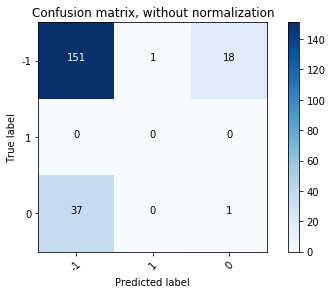


	X = SECURITY HABIT VARIABLES


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


	Best Parameters: {'n_neighbors': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 1.00
	Accuracy on test data:     0.74
	Precision: 0.75
	Recall: 0.74
	F1 Score: 0.74
	Cohen's Kappa: 0.12


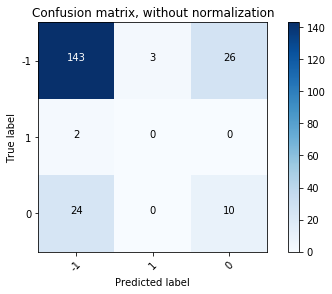


Y = SECUR2B (Other sensitive info compromised)
	Observations in class 1: 402 (38.65%)
	Observations in class -1: 628 (60.38%)
	Observations in class 0: 10 (0.96%)

	X = DEMOGRAPHIC VARIABLES
	Best Parameters: {'n_neighbors': 20}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.64
	Accuracy on test data:     0.53
	Precision: 0.49
	Recall: 0.53
	F1 Score: 0.46
	Cohen's Kappa: 0.0


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


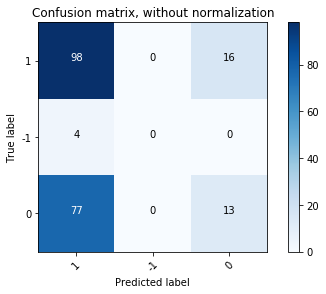


	X = SECURITY HABIT VARIABLES
	Best Parameters: {'n_neighbors': 20}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.62
	Accuracy on test data:     0.56
	Precision: 0.5
	Recall: 0.56
	F1 Score: 0.48

/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



	Cohen's Kappa: 0.01


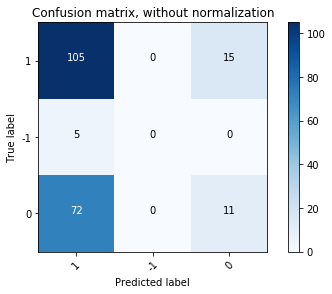


Y = SECUR2C (Fraudulent charges on credit/debit card)
	Observations in class 1: 475 (45.67%)
	Observations in class -1: 561 (53.94%)
	Observations in class 0: 4 (0.38%)

	X = DEMOGRAPHIC VARIABLES
	Best Parameters: {'n_neighbors': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 1.00
	Accuracy on test data:     0.46
	Precision: 0.47
	Recall: 0.46
	F1 Score: 0.46
	Cohen's Kappa: -0.07


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


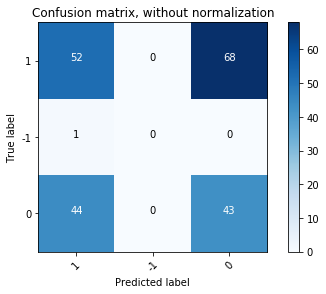


	X = SECURITY HABIT VARIABLES
	Best Parameters: {'n_neighbors': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 1.00
	Accuracy on test data:     0.46
	Precision: 0.46
	Recall: 0.46
	F1 Score: 0.46
	Cohen's Kappa: -0.08


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


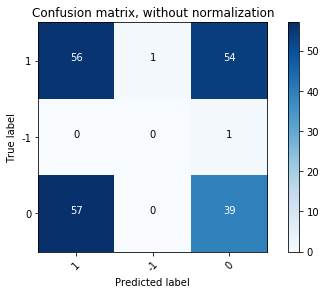


Y = SECUR2D (Someone took over email)
	Observations in class 1: 175 (16.83%)
	Observations in class -1: 855 (82.21%)
	Observations in class 0: 10 (0.96%)

	X = DEMOGRAPHIC VARIABLES
	Best Parameters: {'n_neighbors': 5}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.84
	Accuracy on test data:     0.79
	Precision: 0.69
	Recall: 0.79
	F1 Score: 0.72
	Cohen's Kappa: 0.0


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


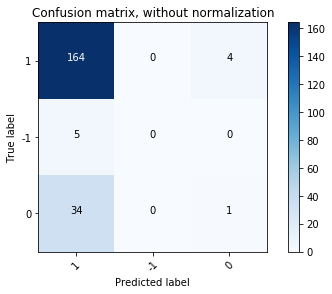


	X = SECURITY HABIT VARIABLES
	Best Parameters: {'n_neighbors': 5}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.84
	Accuracy on test data:     0.80
	Precision: 0.7
	Recall: 0.8
	F1 Score: 0.75
	Cohen's Kappa: -0.06


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


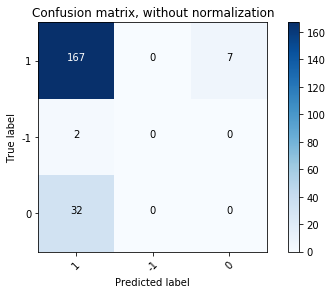


Y = SECUR2E (Someone took over social media account)
	Observations in class -1: 798 (76.73%)
	Observations in class 0: 119 (11.44%)
	Observations in class 1: 123 (11.83%)

	X = DEMOGRAPHIC VARIABLES
	Best Parameters: {'n_neighbors': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 1.00
	Accuracy on test data:     0.66
	Precision: 0.69
	Recall: 0.66
	F1 Score: 0.68
	Cohen's Kappa: 0.09


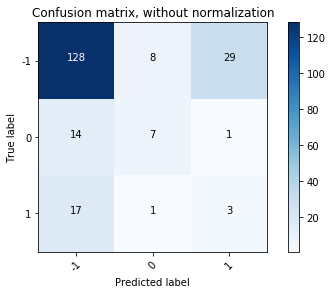


	X = SECURITY HABIT VARIABLES
	Best Parameters: {'n_neighbors': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 1.00
	Accuracy on test data:     0.68
	Precision: 0.66
	Recall: 0.68
	F1 Score: 0.67
	Cohen's Kappa: 0.14


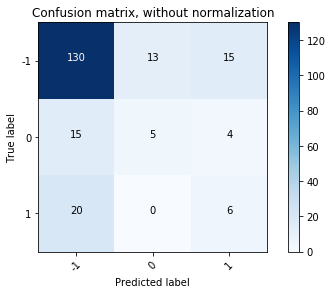


Y = SECUR2F (Someone opened line of credit/applied for loan under name)
	Observations in class -1: 871 (83.75%)
	Observations in class 1: 153 (14.71%)
	Observations in class 0: 16 (1.54%)

	X = DEMOGRAPHIC VARIABLES
	Best Parameters: {'n_neighbors': 10}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.84
	Accuracy on test data:     0.84
	Precision: 0.71
	Recall: 0.84
	F1 Score: 0.77
	Cohen's Kappa: 0.0


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


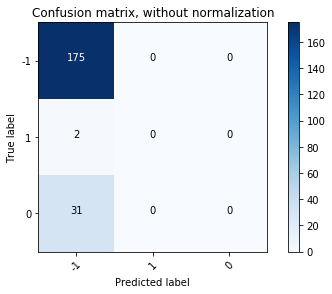


	X = SECURITY HABIT VARIABLES
	Best Parameters: {'n_neighbors': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 1.00
	Accuracy on test data:     0.75
	Precision: 0.76
	Recall: 0.75
	F1 Score: 0.75
	Cohen's Kappa: -0.03


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


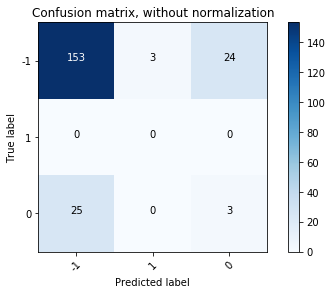


Y = SECUR2G (Someone received tax refund under name)
	Observations in class -1: 970 (93.27%)
	Observations in class 1: 57 (5.48%)
	Observations in class 0: 13 (1.25%)

	X = DEMOGRAPHIC VARIABLES
	Best Parameters: {'n_neighbors': 10}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.93
	Accuracy on test data:     0.94
	Precision: 0.89
	Recall: 0.94
	F1 Score: 0.91
	Cohen's Kappa: 0.0


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


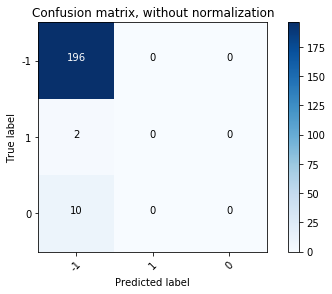


	X = SECURITY HABIT VARIABLES
	Best Parameters: {'n_neighbors': 5}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.93
	Accuracy on test data:     0.93
	Precision: 0.87
	Recall: 0.93
	F1 Score: 0.9
	Cohen's Kappa: 0.0

/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


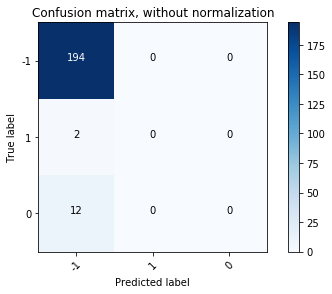

In [21]:
from sklearn.neighbors import KNeighborsClassifier

# create dictionary of parameters
dict_params = {'n_neighbors': [1, 5, 10, 15, 20]}

# set scoring method for cv_optimize (Cohen's Kappa)
scorer = metrics.make_scorer(metrics.cohen_kappa_score)

# Iterate through security incident columns and perform logistic regression
for y_col in sec_cols:

    if y_col != 'ID':
        
        print('\nY = ' + y_col.upper() + ' (' + dict_sec_cols[y_col] + ')')
        
        calc_prop_class(df, y_col)
        
        # remove rows where y_col is don't know/refused (0)
        #knn_df = df[df[y_col] != 0]
        clf_df = df
        
        # ============= Perform knn with demographic variables as features ============= #
        print('\n\tX = DEMOGRAPHIC VARIABLES') 
        clf, Xtrain, ytrain, Xtest, ytest  = do_classify(clf=KNeighborsClassifier(), 
                                                         parameters=dict_params, 
                                                         in_df=clf_df,
                                                         feature_names=dem_cols,
                                                         targetname=y_col,
                                                         target1val=1,
                                                         standardize=False,
                                                         train_size=0.8,
                                                         scorer=scorer)
        
        # ============= Perform knn with security habit variables as features ============= #
        print('\n\tX = SECURITY HABIT VARIABLES')
        clf, Xtrain, ytrain, Xtest, ytest  = do_classify(clf=KNeighborsClassifier(), 
                                                         parameters=dict_params, 
                                                         in_df=clf_df,
                                                         feature_names=hab_cols,
                                                         targetname=y_col,
                                                         target1val=1,
                                                         standardize=False,
                                                         train_size=0.8,
                                                         scorer=scorer)

<div class="alert alert-success">
<h1>RANDOM FORESTS</h1>
</div>


Y = SECUR2A (SSN compromised)

	X = DEMOGRAPHIC VARIABLES
	Best Parameters: {'n_estimators': 10}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.97
	Accuracy on test data:     0.83
	Precision: 0.73
	Recall: 0.83
	F1 Score: 0.78
	Cohen's Kappa: -0.04


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


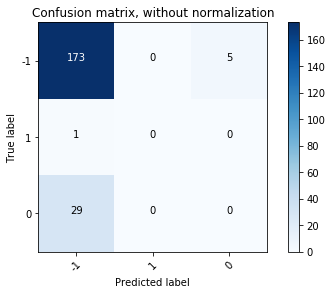


	X = SECURITY HABIT VARIABLES


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


	Best Parameters: {'n_estimators': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.88
	Accuracy on test data:     0.73
	Precision: 0.71
	Recall: 0.73
	F1 Score: 0.72
	Cohen's Kappa: 0.03


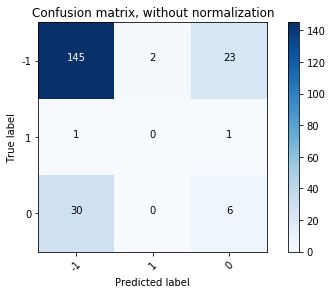


Y = SECUR2B (Other sensitive info compromised)

	X = DEMOGRAPHIC VARIABLES
	Best Parameters: {'n_estimators': 5}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.94
	Accuracy on test data:     0.53
	Precision: 0.53
	Recall: 0.53
	F1 Score: 0.53
	Cohen's Kappa: 0.03


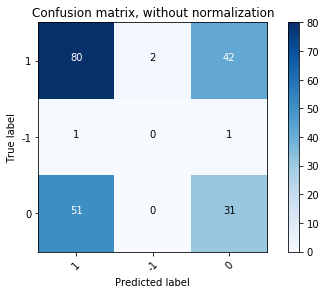


	X = SECURITY HABIT VARIABLES
	Best Parameters: {'n_estimators': 20}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.99
	Accuracy on test data:     0.50
	Precision: 0.49
	Recall: 0.5
	F1 Score: 0.49
	Cohen's Kappa: -0.03


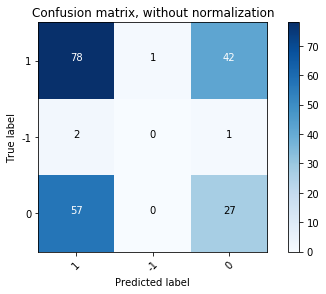


Y = SECUR2C (Fraudulent charges on credit/debit card)

	X = DEMOGRAPHIC VARIABLES


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


	Best Parameters: {'n_estimators': 10}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.98
	Accuracy on test data:     0.61
	Precision: 0.61
	Recall: 0.61
	F1 Score: 0.61
	Cohen's Kappa: 0.22


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


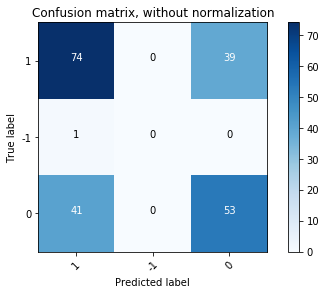


	X = SECURITY HABIT VARIABLES


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


	Best Parameters: {'n_estimators': 20}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 1.00
	Accuracy on test data:     0.55
	Precision: 0.55
	Recall: 0.55
	F1 Score: 0.55
	Cohen's Kappa: 0.08


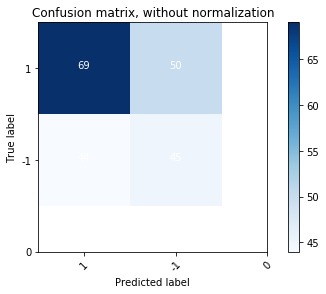


Y = SECUR2D (Someone took over email)

	X = DEMOGRAPHIC VARIABLES
	Best Parameters: {'n_estimators': 5}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.98
	Accuracy on test data:     0.80
	Precision: 0.77
	Recall: 0.8
	F1 Score: 0.78
	Cohen's Kappa: 0.05


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


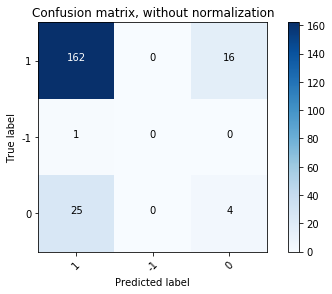


	X = SECURITY HABIT VARIABLES
	Best Parameters: {'n_estimators': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.92
	Accuracy on test data:     0.73
	Precision: 0.76
	Recall: 0.73
	F1 Score: 0.74
	Cohen's Kappa: 0.19


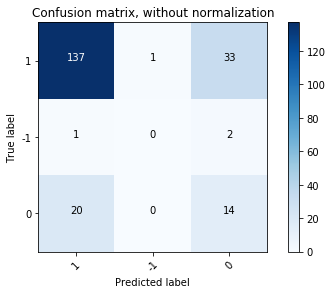


Y = SECUR2E (Someone took over social media account)

	X = DEMOGRAPHIC VARIABLES
	Best Parameters: {'n_estimators': 5}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.96
	Accuracy on test data:     0.76
	Precision: 0.69
	Recall: 0.76
	F1 Score: 0.7
	Cohen's Kappa: 0.15


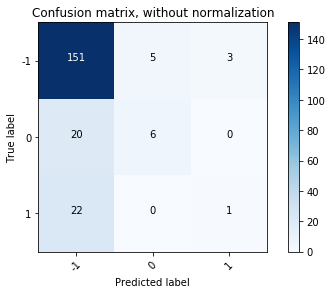


	X = SECURITY HABIT VARIABLES
	Best Parameters: {'n_estimators': 15}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.99
	Accuracy on test data:     0.88
	Precision: 0.83
	Recall: 0.88
	F1 Score: 0.84
	Cohen's Kappa: 0.64


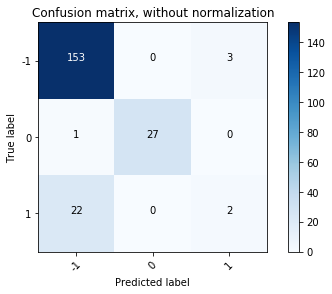


Y = SECUR2F (Someone opened line of credit/applied for loan under name)

	X = DEMOGRAPHIC VARIABLES
	Best Parameters: {'n_estimators': 5}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.96
	Accuracy on test data:     0.82
	Precision: 0.76
	Recall: 0.82
	F1 Score: 0.79
	Cohen's Kappa: -0.03


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


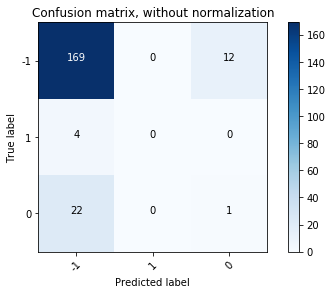


	X = SECURITY HABIT VARIABLES
	Best Parameters: {'n_estimators': 15}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.98
	Accuracy on test data:     0.79
	Precision: 0.67
	Recall: 0.79
	F1 Score: 0.73
	Cohen's Kappa: -0.05


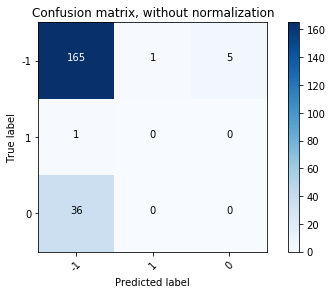


Y = SECUR2G (Someone received tax refund under name)

	X = DEMOGRAPHIC VARIABLES
	Best Parameters: {'n_estimators': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.95
	Accuracy on test data:     0.86
	Precision: 0.89
	Recall: 0.86
	F1 Score: 0.87
	Cohen's Kappa: 0.01


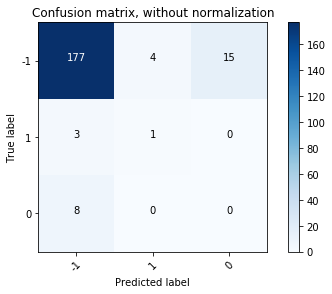


	X = SECURITY HABIT VARIABLES
	Best Parameters: {'n_estimators': 5}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.98
	Accuracy on test data:     0.92
	Precision: 0.87
	Recall: 0.92
	F1 Score: 0.9
	Cohen's Kappa: -0.01


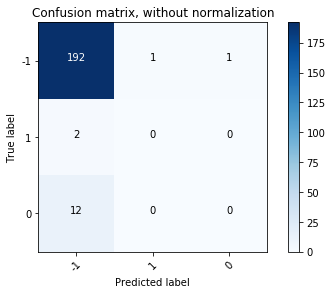

In [22]:
from sklearn.ensemble import RandomForestClassifier

dict_params = {'n_estimators': [1, 5, 10, 15, 20]}

# set scoring method for cv_optimize (Cohen's Kappa)
scorer = metrics.make_scorer(metrics.cohen_kappa_score)

# Iterate through security incident columns and perform logistic regression
for y_col in sec_cols:

    if y_col != 'ID':
        
        print('\nY = ' + y_col.upper() + ' (' + dict_sec_cols[y_col] + ')')
        
        # remove rows where y_col is don't know/refused (0)
        #knn_df = df[df[y_col] != 0]
        clf_df = df
        
        # ============= Perform random forests with demographic variables as features ============= #
        print('\n\tX = DEMOGRAPHIC VARIABLES') 
        clf, Xtrain, ytrain, Xtest, ytest  = do_classify(clf=RandomForestClassifier(), 
                                                         parameters=dict_params, 
                                                         in_df=clf_df,
                                                         feature_names=dem_cols,
                                                         targetname=y_col,
                                                         target1val=1,
                                                         standardize=False,
                                                         train_size=0.8,
                                                         scorer=scorer)
        
        # ============= Perform random forests with security habit variables as features ============= #
        print('\n\tX = SECURITY HABIT VARIABLES')
        clf, Xtrain, ytrain, Xtest, ytest  = do_classify(clf=RandomForestClassifier(), 
                                                         parameters=dict_params, 
                                                         in_df=clf_df,
                                                         feature_names=hab_cols,
                                                         targetname=y_col,
                                                         target1val=1,
                                                         standardize=False,
                                                         train_size=0.8,
                                                         scorer=scorer)

<div class="alert alert-success">
<h1>SVC</h1>
</div>

SVC models represent data as points in space, mapped so that the data of the different categories are divided by a gap that's as wide as possible 
* C: parameter for slack variables; trades off misclassification of training examples against simplicity of decision surface (low values = allows more slack, ensures hyperplane won't change dramatically for outliers)
* Gamma: how far the influence of a single training sample reaches (low values = 'far')


Y = SECUR2A (SSN compromised)

	X = DEMOGRAPHIC VARIABLES
	Best Parameters: {'C': 1.2589254117941673, 'gamma': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 1.00
	Accuracy on test data:     0.81
	Precision: 0.65
	Recall: 0.81
	F1 Score: 0.72
	Cohen's Kappa: 0.0


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


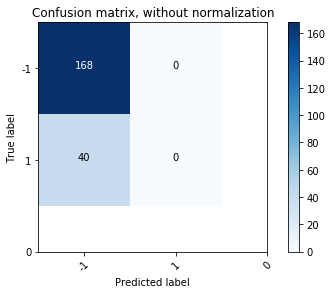


	X = SECURITY HABIT VARIABLES
	Best Parameters: {'C': 1.2589254117941673, 'gamma': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 1.00
	Accuracy on test data:     0.83
	Precision: 0.69
	Recall: 0.83
	F1 Score: 0.76
	Cohen's Kappa: 0.0


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


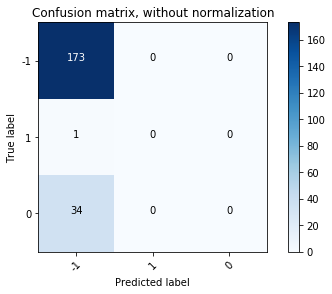


Y = SECUR2B (Other sensitive info compromised)

	X = DEMOGRAPHIC VARIABLES
	Best Parameters: {'C': 1.2589254117941673, 'gamma': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 1.00
	Accuracy on test data:     0.61
	Precision: 0.37
	Recall: 0.61
	F1 Score: 0.46
	Cohen's Kappa: 0.0


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


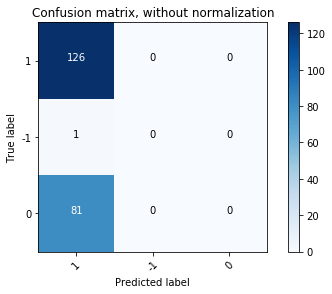


	X = SECURITY HABIT VARIABLES
	Best Parameters: {'C': 1.2589254117941673, 'gamma': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 1.00
	Accuracy on test data:     0.57
	Precision: 0.33
	Recall: 0.57
	F1 Score: 0.42
	Cohen's Kappa: 0.0


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


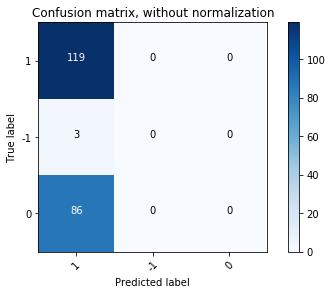


Y = SECUR2C (Fraudulent charges on credit/debit card)

	X = DEMOGRAPHIC VARIABLES


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


	Best Parameters: {'C': 1.2589254117941673, 'gamma': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 1.00
	Accuracy on test data:     0.53
	Precision: 0.28
	Recall: 0.53
	F1 Score: 0.37
	Cohen's Kappa: 0.0


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


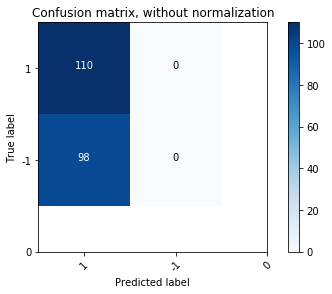


	X = SECURITY HABIT VARIABLES


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


	Best Parameters: {'C': 1.2589254117941673, 'gamma': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 1.00
	Accuracy on test data:     0.54
	Precision: 0.3
	Recall: 0.54
	F1 Score: 0.38
	Cohen's Kappa: 0.0


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


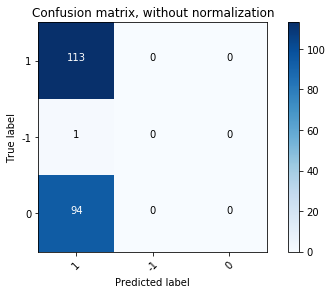


Y = SECUR2D (Someone took over email)

	X = DEMOGRAPHIC VARIABLES
	Best Parameters: {'C': 1.2589254117941673, 'gamma': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 1.00
	Accuracy on test data:     0.80
	Precision: 0.64
	Recall: 0.8
	F1 Score: 0.71
	Cohen's Kappa: 0.0


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


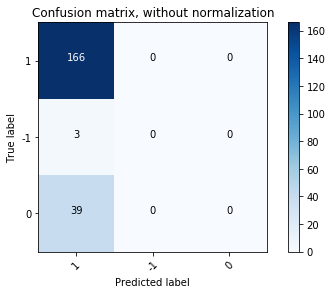


	X = SECURITY HABIT VARIABLES
	Best Parameters: {'C': 1.2589254117941673, 'gamma': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 1.00
	Accuracy on test data:     0.81
	Precision: 0.66
	Recall: 0.81
	F1 Score: 0.73
	Cohen's Kappa: 0.0


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


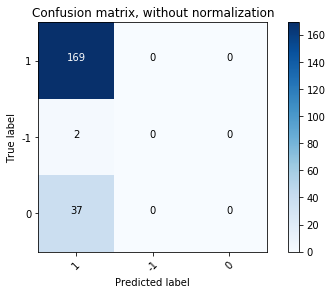


Y = SECUR2E (Someone took over social media account)

	X = DEMOGRAPHIC VARIABLES
	Best Parameters: {'C': 1.2589254117941673, 'gamma': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 1.00
	Accuracy on test data:     0.78
	Precision: 0.61
	Recall: 0.78
	F1 Score: 0.68
	Cohen's Kappa: 0.0


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


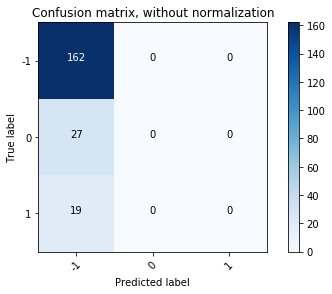


	X = SECURITY HABIT VARIABLES
	Best Parameters: {'C': 1.2589254117941673, 'gamma': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 1.00
	Accuracy on test data:     0.81
	Precision: 0.66
	Recall: 0.81
	F1 Score: 0.73
	Cohen's Kappa: 0.0


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


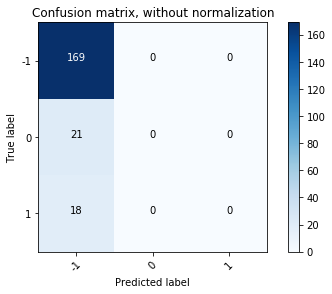


Y = SECUR2F (Someone opened line of credit/applied for loan under name)

	X = DEMOGRAPHIC VARIABLES
	Best Parameters: {'C': 1.2589254117941673, 'gamma': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 1.00
	Accuracy on test data:     0.82
	Precision: 0.67
	Recall: 0.82
	F1 Score: 0.74
	Cohen's Kappa: 0.0


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


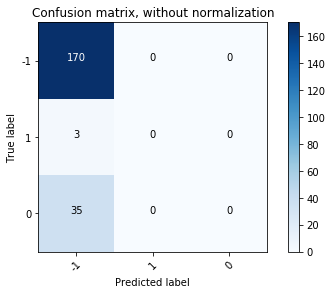


	X = SECURITY HABIT VARIABLES
	Best Parameters: {'C': 1.2589254117941673, 'gamma': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 1.00
	Accuracy on test data:     0.87
	Precision: 0.75
	Recall: 0.87
	F1 Score: 0.8
	Cohen's Kappa: 0.0


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


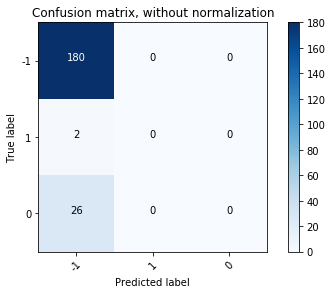


Y = SECUR2G (Someone received tax refund under name)

	X = DEMOGRAPHIC VARIABLES
	Best Parameters: {'C': 1.2589254117941673, 'gamma': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 1.00
	Accuracy on test data:     0.94
	Precision: 0.88
	Recall: 0.94
	F1 Score: 0.91
	Cohen's Kappa: 0.0


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


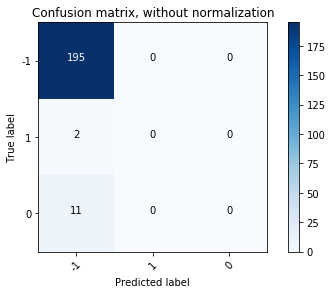


	X = SECURITY HABIT VARIABLES
	Best Parameters: {'C': 1.2589254117941673, 'gamma': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 1.00
	Accuracy on test data:     0.94
	Precision: 0.88
	Recall: 0.94
	F1 Score: 0.91
	Cohen's Kappa: 0.0


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


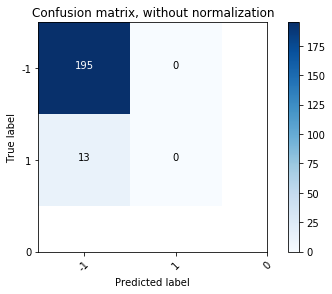

In [23]:
from sklearn.svm import SVC

# create dictionary of parameters
dict_params = {'C': [10**0.1, 10**0, 10**1],
               'gamma': [10**0, 10**0.1, 10**1]}

# set scoring method for cv_optimize (Cohen's Kappa)
scorer = metrics.make_scorer(metrics.cohen_kappa_score)

# Iterate through security incident columns and perform logistic regression
for y_col in sec_cols:

    if y_col != 'ID':
        
        print('\nY = ' + y_col.upper() + ' (' + dict_sec_cols[y_col] + ')')
        
        # remove rows where y_col is don't know/refused (0)
        #svm_df = df[df[y_col] != 0]
        clf_df = df
        
        # ============= Perform SVM with demographic variables as features ============= #        
        print('\n\tX = DEMOGRAPHIC VARIABLES')        
        clf, Xtrain, ytrain, Xtest, ytest  = do_classify(clf=SVC(), 
                                                         parameters=dict_params, 
                                                         in_df=clf_df,
                                                         feature_names=dem_cols,
                                                         targetname=y_col,
                                                         target1val=1,
                                                         standardize=False,
                                                         train_size=0.8,
                                                         scorer=scorer)
        
        # ============= Perform SVM with security habit variables as features ============= #
        print('\n\tX = SECURITY HABIT VARIABLES')
        clf, Xtrain, ytrain, Xtest, ytest  = do_classify(clf=SVC(), 
                                                         parameters=dict_params, 
                                                         in_df=clf_df,
                                                         feature_names=hab_cols,
                                                         targetname=y_col,
                                                         target1val=1,
                                                         standardize=False,
                                                         train_size=0.8,
                                                         scorer=scorer)

<div class="alert alert-success">
<h1>CLUSTERING</h1>
</div>

### Calculate best k function
Given a set of columns and a range of k values, performs kmeans clustering, calculates the highest average silhouette score, and return k with largest score

In [24]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

def calc_best_k(x_cols, k_range):
    
    best_score = -np.inf
    best_k = -np.inf
    
    for k in k_range:
        
        clusterer = KMeans(n_clusters = k)
        cluster_labels = clusterer.fit_predict(x_cols)
    
        silhouette_avg = silhouette_score(x_cols, cluster_labels)
        
        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_k = k

    print('\tHighest average silhouette score ({:.3f}) was for {:d} clusters'.format(best_score, best_k))
    
    return best_k

### Perform clustering

In [25]:
from sklearn import metrics
from sklearn.cluster import KMeans

dict_params = {'k': [2, 3, 4, 5]}

# Iterate through security incident columns perform clustering
for y_col in sec_cols:

    if y_col != 'ID':
        
        print('\nY = ' + y_col.upper() + ' (' + dict_sec_cols[y_col] + ')')
        
        # ============= Perform clustering with demographic variables as features ============= #        
        print('\n\tX = DEMOGRAPHIC VARIABLES') 
        
        x_cols = np.matrix(df_dem.ix[:, 1:])
        k_range = range(2,5)
        k = calc_best_k(x_cols, k_range)
        
        # create model
        clusterer = KMeans(n_clusters = k)
        cluster_labels = clusterer.fit_predict(x_cols)
        
        # calculate and print adjusted Rand index
        adjrand = metrics.adjusted_rand_score(df[y_col], cluster_labels)
        print('\tAdjusted Rand Index: {:.3f}'.format(adjrand))
        
        # ============= Perform clustering with security habit variables as features ============= #        
        print('\n\tX = SECURITY HABIT VARIABLES')
        
        x_cols = np.matrix(df_hab.ix[:, 1:])
        k_range = range(2,5)
        k = calc_best_k(x_cols, k_range)
        
        clusterer = KMeans(n_clusters = k)
        cluster_labels = clusterer.fit_predict(x_cols)
        n_clusters = len(cluster_labels)
        
        # calculate and print adjusted Rand index
        adjrand = metrics.adjusted_rand_score(df[y_col], cluster_labels)
        print('\tAdjusted Rand Index: {:.3f}'.format(adjrand))


Y = SECUR2A (SSN compromised)

	X = DEMOGRAPHIC VARIABLES
	Highest average silhouette score (0.763) was for 2 clusters
	Adjusted Rand Index: -0.013

	X = SECURITY HABIT VARIABLES
	Highest average silhouette score (0.174) was for 4 clusters
	Adjusted Rand Index: -0.009

Y = SECUR2B (Other sensitive info compromised)

	X = DEMOGRAPHIC VARIABLES
	Highest average silhouette score (0.763) was for 2 clusters
	Adjusted Rand Index: -0.008

	X = SECURITY HABIT VARIABLES
	Highest average silhouette score (0.174) was for 4 clusters
	Adjusted Rand Index: -0.001

Y = SECUR2C (Fraudulent charges on credit/debit card)

	X = DEMOGRAPHIC VARIABLES
	Highest average silhouette score (0.763) was for 2 clusters
	Adjusted Rand Index: 0.001

	X = SECURITY HABIT VARIABLES
	Highest average silhouette score (0.174) was for 4 clusters
	Adjusted Rand Index: 0.009

Y = SECUR2D (Someone took over email)

	X = DEMOGRAPHIC VARIABLES
	Highest average silhouette score (0.763) was for 2 clusters
	Adjusted Rand Index: -

<div class="alert alert-success">
<h1>DBSCAN</h1>
</div>

### Calculate best min_samples function
Given a set of columns and a range of min_samples, performs DBSCAN, calculates the highest average silhouette score, and return min_samples with largest score

In [26]:
from sklearn.metrics import silhouette_samples, silhouette_score

def calc_best_ms(x_cols, ms_range):
    
    best_score = -np.inf
    best_ms = -np.inf
    
    for ms in ms_range:
        
        db = DBSCAN(min_samples = ms)       
        labels = db.fit_predict(x_cols)      
        silhouette_avg = silhouette_score(x_cols, labels)
        
        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_ms = ms

    print('\tHighest average silhouette score ({:.3f}) was for {:d} min_samples'.format(best_score, best_ms))
    
    return best_ms

### Perform DBSCAN

In [27]:
from sklearn.cluster import DBSCAN

# Iterate through security incident columns perform clustering
for y_col in sec_cols:

    if y_col != 'ID':
        
        print('\nY = ' + y_col.upper() + ' (' + dict_sec_cols[y_col] + ')')
        
        # ============= Perform DBSCAN with security habit variables as features ============= #        
        print('\n\tX = SECURITY HABIT VARIABLES') 
        
        x_cols = np.matrix(df_hab.ix[:, 1:])
        ms_range = range(2,20)
        ms = calc_best_ms(x_cols, ms_range)
        
        db = DBSCAN(min_samples = ms)
        db.fit(x_cols)
        labels = db.labels_
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        print('\tEstimated number of clusters: %d' % n_clusters_)
        
        # calculate and print adjusted Rand index
        adjrand = metrics.adjusted_rand_score(df[y_col], cluster_labels)
        print('\tAdjusted Rand Index: {:.3f}'.format(adjrand))


Y = SECUR2A (SSN compromised)

	X = SECURITY HABIT VARIABLES
	Highest average silhouette score (0.133) was for 12 min_samples
	Estimated number of clusters: 2
	Adjusted Rand Index: -0.009

Y = SECUR2B (Other sensitive info compromised)

	X = SECURITY HABIT VARIABLES
	Highest average silhouette score (0.133) was for 12 min_samples
	Estimated number of clusters: 2
	Adjusted Rand Index: -0.001

Y = SECUR2C (Fraudulent charges on credit/debit card)

	X = SECURITY HABIT VARIABLES
	Highest average silhouette score (0.133) was for 12 min_samples
	Estimated number of clusters: 2
	Adjusted Rand Index: 0.008

Y = SECUR2D (Someone took over email)

	X = SECURITY HABIT VARIABLES
	Highest average silhouette score (0.133) was for 12 min_samples
	Estimated number of clusters: 2
	Adjusted Rand Index: -0.008

Y = SECUR2E (Someone took over social media account)

	X = SECURITY HABIT VARIABLES
	Highest average silhouette score (0.133) was for 12 min_samples
	Estimated number of clusters: 2
	Adjusted Ran